In [1]:
import ROOT, os, sys, glob
from math import *
ROOT.EnableImplicitMT(4); 

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
Welcome to JupyROOT 6.28/00


In [5]:
list(glob.glob("/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/*125X_v0.2.root"))

['/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_BsToMuMu_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-10To50_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-1To10_TuneCP5_14TeV-pythia8_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-50_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M10_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M12_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M15_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M1p1_filtered_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M1p4_filtered_PU200.125X_v0.2.root',
 '/eos/cms/store/cmst3/group/l1tr

In [9]:
rdf = ROOT.RDataFrame("Events","/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M25_PU200.125X_v0.2.root")

Processed 8957 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


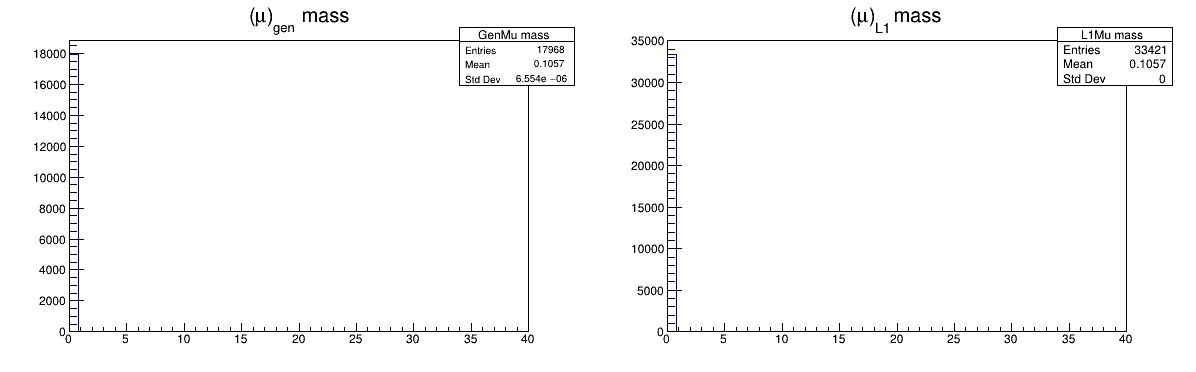

In [12]:
hNGen = rdf.Histo1D(("GenMu mass","(#mu)_{gen} mass",50,0,40), "GenMu_mass")
hNL1 = rdf.Histo1D(("L1Mu mass","(#mu)_{L1} mass",50,0,40), "TkMu_mass")
entries = rdf.Count().GetValue()
print(f"Processed {entries} entries.")
## And plot it
c1 = ROOT.TCanvas("c1","c1", 1200, 400)
c1.Divide(2,1)
c1.cd(1)
hNGen.Draw()
c1.cd(2)
hNL1.Draw()
c1.Draw()

Processed 10000 entries.


Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


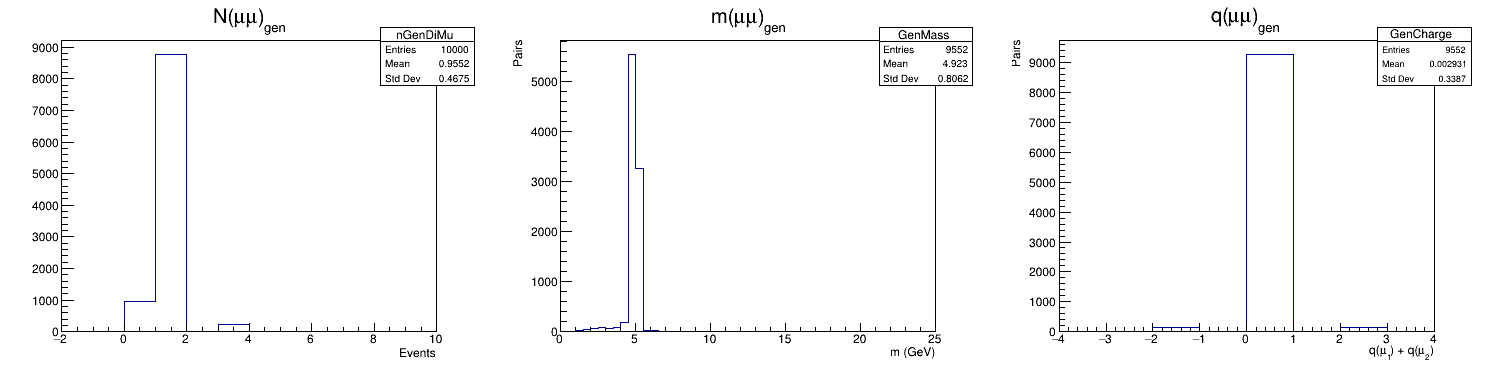

In [4]:
def makeDimuonPairs(name, rdf):
    ## define 4-vectors in cartesian coordinates, for easier 
    rdf = rdf.Define(f"{name}Mu_p4", f"ROOT::VecOps::Construct<ROOT::Math::XYZTVector>(ROOT::VecOps::Construct<ROOT::Math::PtEtaPhiMVector>({name}Mu_pt,{name}Mu_eta,{name}Mu_phi,{name}Mu_mass))")
    ## make indices of all the pairs
    rdf = rdf.Define(f"{name}DiMu_indices", f"""
        ROOT::VecOps::RVec<std::pair<int,int>> ret; 
        for (int i = 0, n = n{name}Mu; i < n; ++i) 
            for (int i2 = i+1; i2 < n; ++i2) 
                ret.emplace_back(i,i2);
        return ret;""")
    
    #Let us impose a selection criteria here
    
    
    ## Make the number of dimuons, for convenience later
    rdf = rdf.Define(f"n{name}DiMu", f"{name}DiMu_indices.size()")
    ## compute the mass, charge
    rdf = rdf.Define(f"{name}DiMu_mass", f"""
        ROOT::RVecF ret; 
        for (const auto & pair : {name}DiMu_indices) 
            ret.emplace_back(({name}Mu_p4[pair.first]+{name}Mu_p4[pair.second]).M());
        return ret;""")
    
    
    rdf = rdf.Define(f"{name}DiMu_charge", f"""
        ROOT::RVecI ret; 
        for (const auto & pair : {name}DiMu_indices) 
            ret.emplace_back({name}Mu_charge[pair.first]+{name}Mu_charge[pair.second]);
        return ret;""")
    
    rdf = rdf.Define(f"{name}TkDiMu_genIdx", f"""
        ROOT::VecOps::RVec<std::pair<int,int>> ret;
        for (const auto & pair : {name}DiMu_indices) 
            ret.emplace_back(TkMu_GenMuIdx[pair.first],TkMu_GenMuIdx[pair.second]);
        return ret;""")
    
    rdf = rdf.Define(f"{name}DiMu_minIdx", f"""
        ROOT::RVecI ret;
        for (const auto & pair : {name}DiMu_indices) 
            ret.emplace_back(std::min(TkMu_GenMuIdx[pair.first],TkMu_GenMuIdx[pair.second]));
        return ret;""")
    
    return rdf;


rdf_gendimu = makeDimuonPairs("Gen", rdf)

## Now we make a plot of the number of generated muons and the ones reconstructed by L1T
hNGenPairs = rdf_gendimu.Histo1D(("nGenDiMu","N(#mu#mu)_{gen};Events",12,-2,10), "nGenDiMu")
hGenPairMass = rdf_gendimu.Histo1D(("GenMass","m(#mu#mu)_{gen};m (GeV);Pairs",50,0,25), "GenDiMu_mass")
hGenPairCharge = rdf_gendimu.Histo1D(("GenCharge","q(#mu#mu)_{gen};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "GenDiMu_charge")
entries = rdf_gendimu.Count().GetValue()
print(f"Processed {entries} entries.")

rdf_gendimu.Describe()
## And plot it
c1 = ROOT.TCanvas("c1","c1", 1500, 400)
c1.Divide(3,1)
for i, h in enumerate([hNGenPairs,hGenPairMass,hGenPairCharge]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

Processed 10000 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


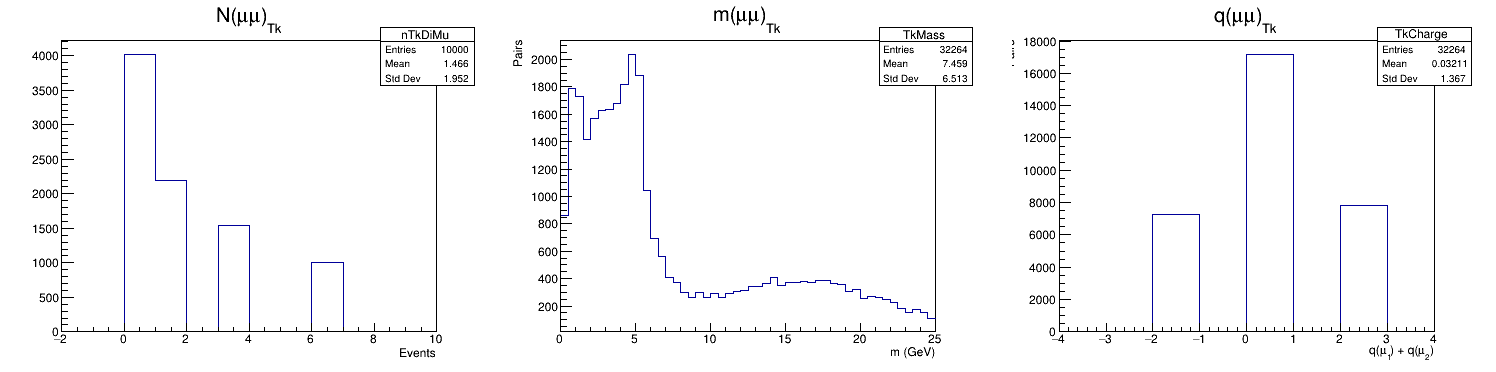

In [5]:
rdf_Tkdimu = makeDimuonPairs("Tk", rdf_gendimu)

## Now we make a plot of the number of generated muons and the ones reconstructed by L1T
hNTkPairs = rdf_Tkdimu.Histo1D(("nTkDiMu","N(#mu#mu)_{Tk};Events",12,-2,10), "nTkDiMu")
hTkPairMass = rdf_Tkdimu.Histo1D(("TkMass","m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,25), "TkDiMu_mass")
hTkPairCharge = rdf_Tkdimu.Histo1D(("TkCharge","q(#mu#mu)_{Tk};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "TkDiMu_charge")
entries = rdf_Tkdimu.Count().GetValue()
print(f"Processed {entries} entries.")

c1 = ROOT.TCanvas("c1","c1", 1500, 400)
c1.Divide(3,1)
for i, h in enumerate([hNTkPairs,hTkPairMass,hTkPairCharge]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

Processed 10000 entries.


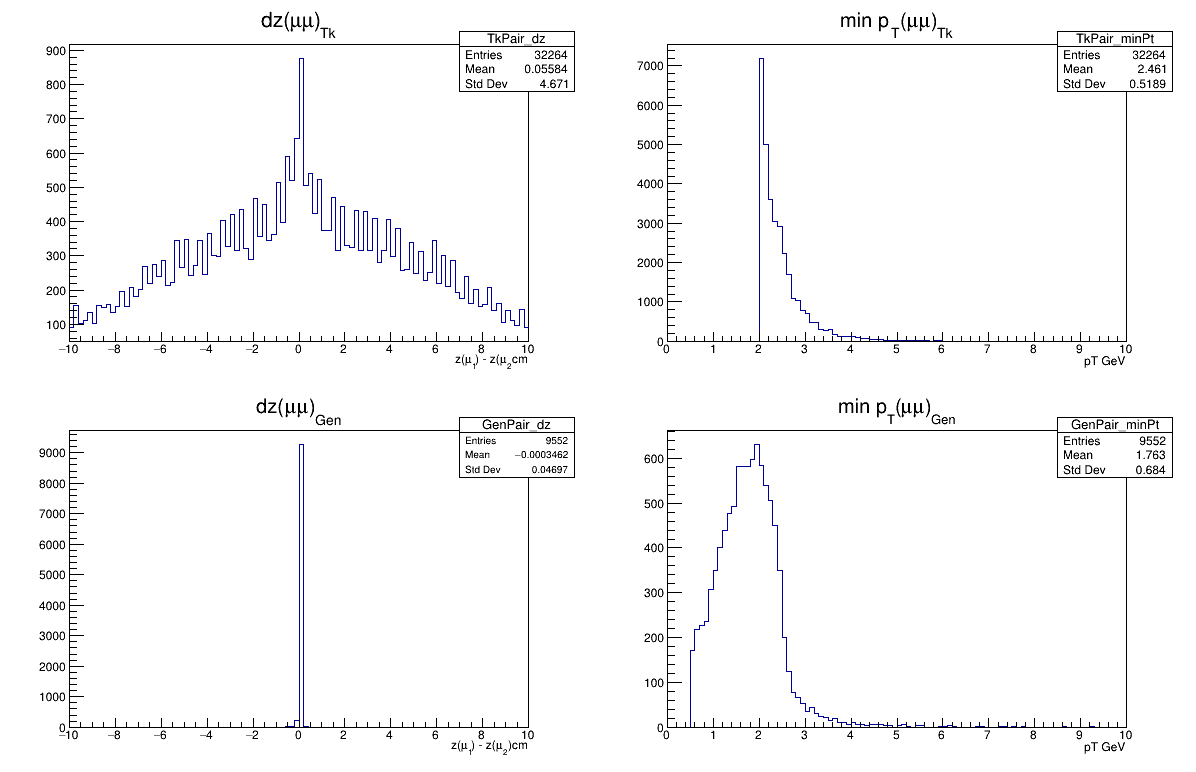

In [6]:
def dimuonextra(name,rdf):
    #separation along the beamline
    rdf=rdf.Define(f"{name}DiMu_dz",f"""
    ROOT::RVecF ret;
    for(const auto & pair : {name}DiMu_indices)
        ret.emplace_back(({name}Mu_vz[pair.first]-{name}Mu_vz[pair.second]));
    return ret;""")
    #min pT of thw two
    rdf = rdf.Define(f"{name}Mu_minPT",f"""
    ROOT::RVecF ret;
    for(const auto & pair : {name}DiMu_indices)
        ret.emplace_back(std::min({name}Mu_pt[pair.first],{name}Mu_pt[pair.second]));
    return ret;""") #
    
    return rdf;
rdf_tkextra = dimuonextra("Tk", dimuonextra("Gen", rdf_Tkdimu)) #this is done to essentially include all the newly created Rdfs in the final rdf
hTkPair_Dz = rdf_tkextra.Histo1D(("TkPair_dz","dz(#mu#mu)_{Tk};z(#mu_{1}) - z(#mu_{2}cm",100,-10,10),"TkDiMu_dz")
hTkPair_minPt = rdf_tkextra.Histo1D(("TkPair_minPt","min p_{T}(#mu#mu)_{Tk};pT GeV",100,0,10),"TkMu_minPT")
hGenPair_Dz = rdf_tkextra.Histo1D(("GenPair_dz","dz(#mu#mu)_{Gen};z(#mu_{1}) - z(#mu_{2})cm",100,-10,10),"GenDiMu_dz")
hGenPair_minPt = rdf_tkextra.Histo1D(("GenPair_minPt","min p_{T}(#mu#mu)_{Gen};pT GeV",100,0,10),"GenMu_minPT")


entries = rdf_Tkdimu.Count().GetValue()
print(f"Processed {entries} entries.")

## And plot it
c2 = ROOT.TCanvas("c2","c2", 1200, 800)
c2.Divide(2,2)
for i, h in enumerate([hTkPair_Dz, hTkPair_minPt, hGenPair_Dz, hGenPair_minPt]):
    c2.cd(i+1)
    h.Draw()
c2.Draw()

In [7]:
def select_ind(name, rdf):
    
    #Let us impose a selection criteria here
    #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
    rdf = rdf.Define(f"{name}DiMu_good", f"({name}DiMu_charge<0.1 && {name}DiMu_charge>-0.1) &&({name}DiMu_dz<1 && ({name}DiMu_dz>-1))&&({name}Mu_minPT>2)")                    
    rdf = rdf.Define(f"Good{name}DiMu_indices", f"{name}DiMu_indices[{name}DiMu_good]")
    rdf = rdf.Filter(f"Sum({name}DiMu_good)  >= 1")
    rdf = rdf.Define(f"n{name}DiMu_sel",f"Good{name}DiMu_indices.size()")
    rdf = rdf.Define(f"{name}DiMu_selMass",f"{name}DiMu_mass[{name}DiMu_good]")
    rdf = rdf.Define(f"{name}DiMu_selCharge",f"{name}DiMu_charge[{name}DiMu_good]")
    rdf = rdf.Define(f"{name}DiMu_seldz",f"{name}DiMu_dz[{name}DiMu_good]")
    rdf = rdf.Define(f"{name}DiMu_selMinPt",f"{name}Mu_minPT[{name}DiMu_good]")
    rdf = rdf.Define(f"GoodTkDiMu_minIdx_{name}",f"TkDiMu_minIdx[{name}DiMu_good]")
    return rdf;
rdf_gendisel = select_ind("Gen", rdf_tkextra)

Processed 10000 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


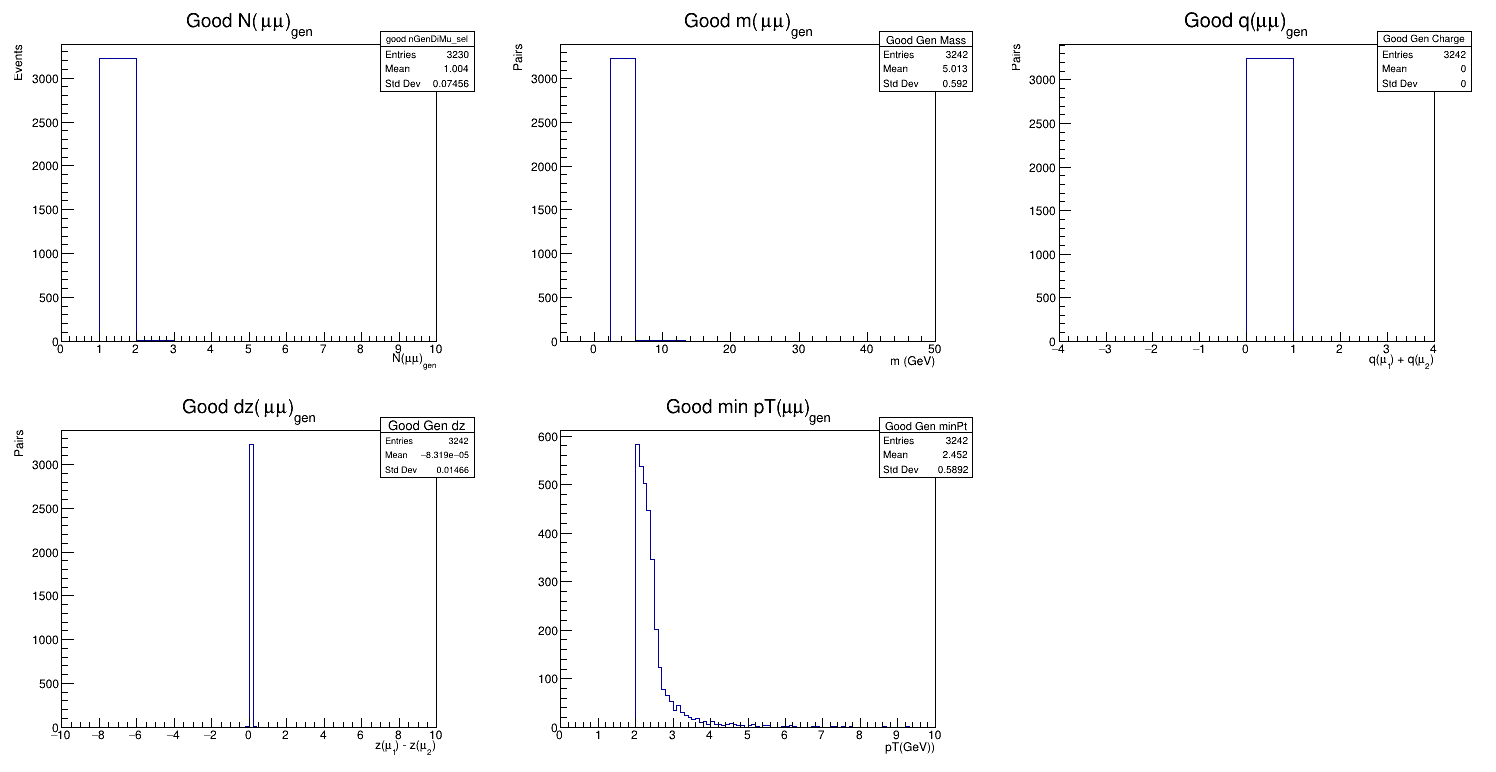

In [8]:
rdf_selFeat = rdf_gendisel
hNGoodGenPairs = rdf_selFeat.Histo1D(("good nGenDiMu_sel","Good N(#mu#mu)_{gen};N(#mu#mu)_{gen};Events",10,0,10), "nGenDiMu_sel")
hGoodGenPairMass = rdf_selFeat.Histo1D(("Good Gen Mass","Good m(#mu#mu)_{gen};m (GeV);Pairs",15,-5,50), "GenDiMu_selMass")
hGoodGenPairCharge = rdf_selFeat.Histo1D(("Good Gen Charge","Good q(#mu#mu)_{gen};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "GenDiMu_selCharge")
hGoodGenPairDz = rdf_selFeat.Histo1D(("Good Gen dz","Good dz(#mu#mu)_{gen};z(#mu_{1}) - z(#mu_{2});Pairs",100,-10,10), "GenDiMu_seldz")
hGoodGenPairMinPT = rdf_selFeat.Histo1D(("Good Gen minPt","Good min pT(#mu#mu)_{gen};pT(GeV))",100,0,10), "GenDiMu_selMinPt")
#entries = rdf_selFeat.Count().GetValue()
print(f"Processed {entries} entries.")
#rdf_selFeat.Describe()
#entries = rdf_selFeat.Count().GetValue()

c1 = ROOT.TCanvas("c1","c1", 1500, 800)
c1.Divide(3,2)
for i, h in enumerate([hNGoodGenPairs, hGoodGenPairMass, hGoodGenPairCharge, hGoodGenPairDz, hGoodGenPairMinPT]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

In [9]:
rdf_select_Tk = select_ind("Tk",rdf_selFeat)
rdf_Tk_selFeat = rdf_select_Tk

Processed 1016 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


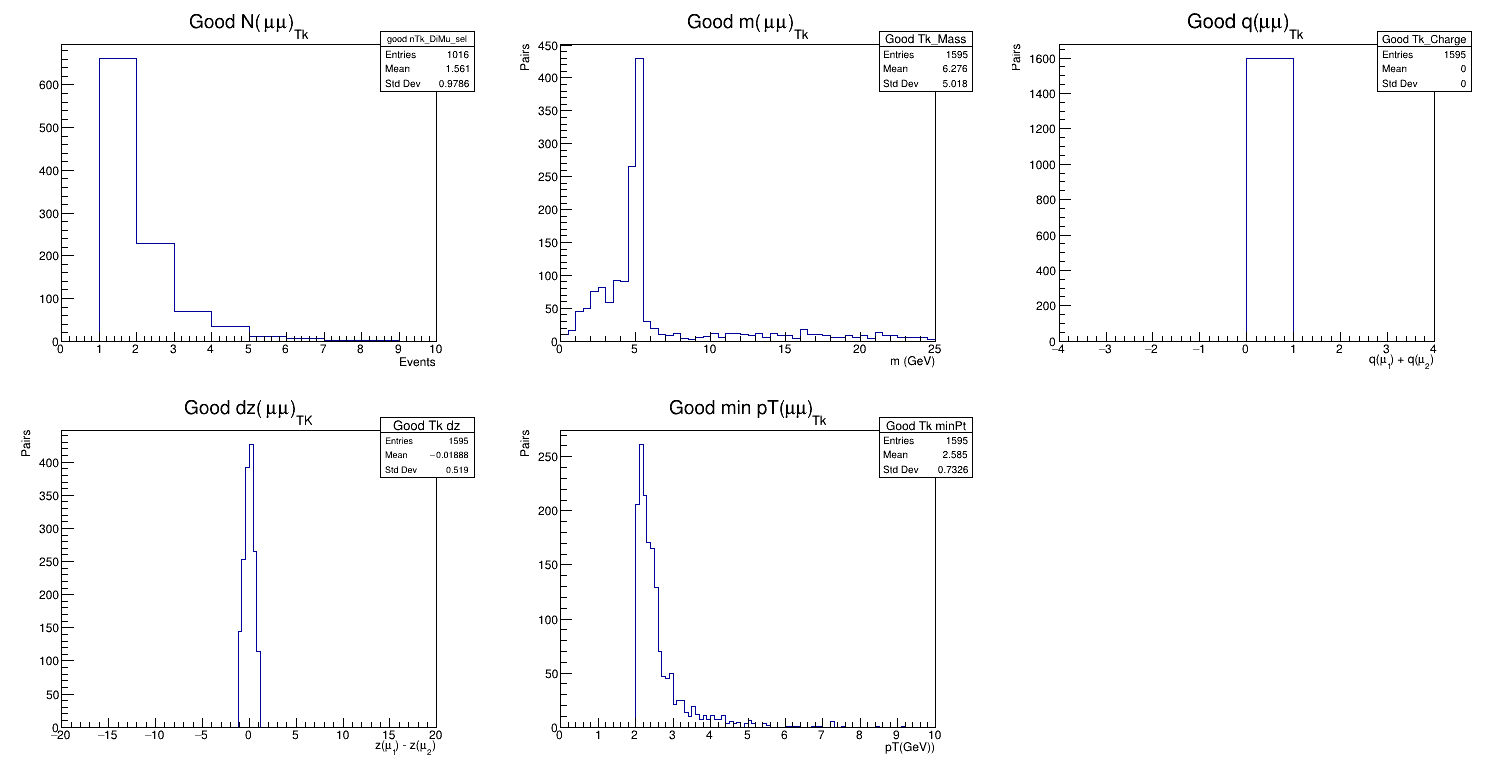

In [10]:
hNGoodTkPairs = rdf_Tk_selFeat.Histo1D(("good nTk_DiMu_sel","Good N(#mu#mu)_{Tk};Events",10,0,10), "nTkDiMu_sel")
hGoodTkPairMass = rdf_Tk_selFeat.Histo1D(("Good Tk_Mass","Good m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,25), "TkDiMu_selMass")
hGoodTkPairCharge = rdf_Tk_selFeat.Histo1D(("Good Tk_Charge","Good q(#mu#mu)_{Tk};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "TkDiMu_selCharge")
hGoodTkPairDz = rdf_Tk_selFeat.Histo1D(("Good Tk dz","Good dz(#mu#mu)_{TK};z(#mu_{1}) - z(#mu_{2});Pairs",100,-20,20), "TkDiMu_seldz")
hGoodTkPairMinPT = rdf_Tk_selFeat.Histo1D(("Good Tk minPt","Good min pT(#mu#mu)_{Tk};pT(GeV));Pairs",100,0,10), "TkDiMu_selMinPt")
entries = rdf_Tk_selFeat.Count().GetValue()
print(f"Processed {entries} entries.")
#rdf_selFeat.Describe()
#entries = rdf_selFeat.Count().GetValue()

c1 = ROOT.TCanvas("c1","c1", 1500, 800)
c1.Divide(3,2)
for i, h in enumerate([hNGoodTkPairs, hGoodTkPairMass, hGoodTkPairCharge, hGoodTkPairDz, hGoodTkPairMinPT]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()

In [11]:
#let us impose another selection on just tracker muons
def indexSelect(rdf):
    rdf = rdf.Define("TkDiMu_indGood","(GoodTkDiMu_minIdx_Tk!=-1)" )
    rdf = rdf.Define(f"IdxDiMu_indices", f"GoodTkDiMu_indices[TkDiMu_indGood]")
    rdf = rdf.Filter(f"Sum(TkDiMu_indGood)  >= 1")
    rdf = rdf.Define(f"nTkDiMu_Idx",f"IdxDiMu_indices.size()")
    rdf = rdf.Define(f"TkDiMu_IdxMass",f"TkDiMu_selMass[TkDiMu_indGood]")
    rdf = rdf.Define(f"TkDiMu_IdxCharge",f"TkDiMu_selCharge[TkDiMu_indGood]")
    rdf = rdf.Define(f"TkDiMu_Idxdz",f"TkDiMu_seldz[TkDiMu_indGood]")
    rdf = rdf.Define(f"TkDiMu_IdxMinPt",f"TkDiMu_selMinPt[TkDiMu_indGood]")
    
    return rdf;

rdf_idxSel = indexSelect(rdf_Tk_selFeat)

Processed 1016 entries.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


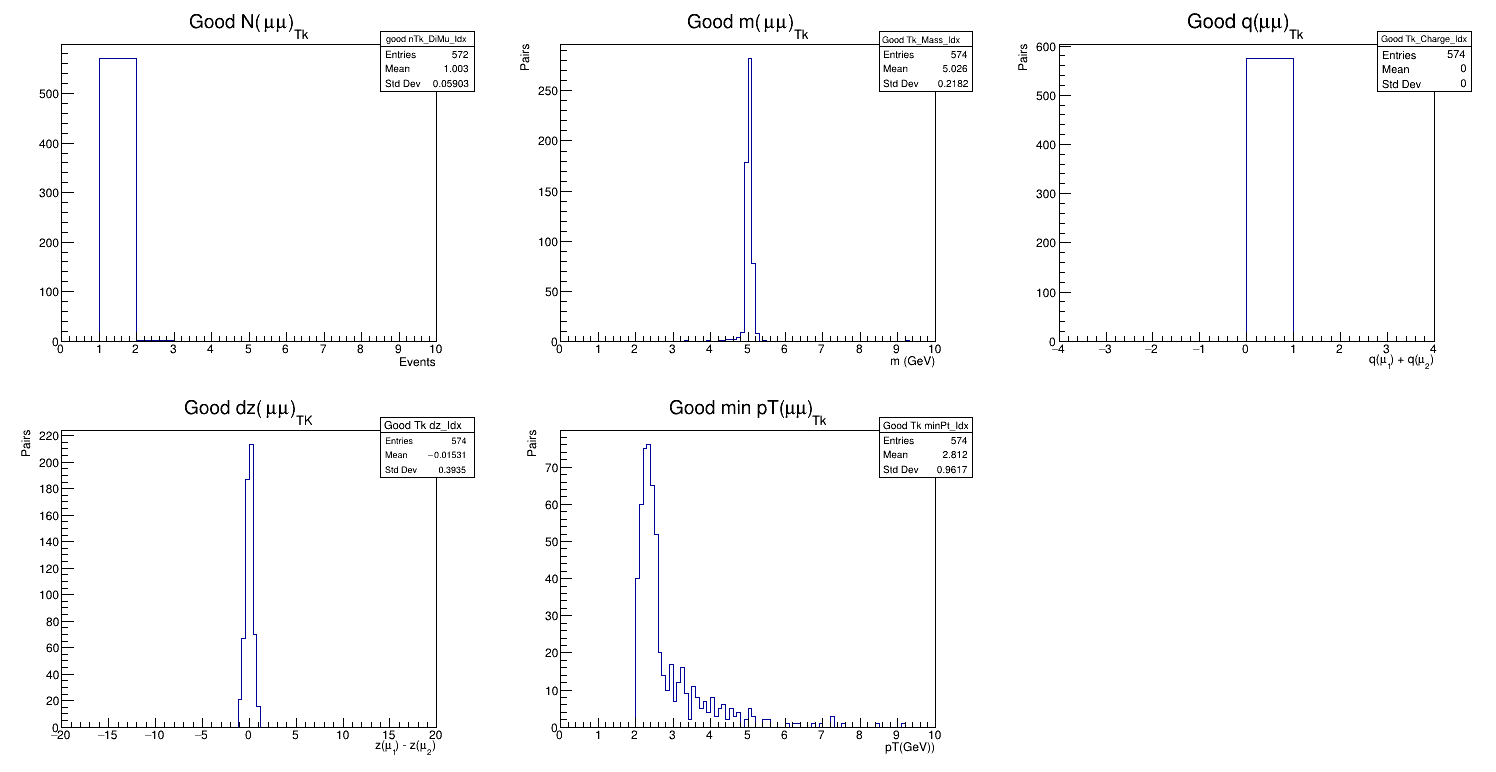

In [12]:
hNIdxTkPairs = rdf_idxSel.Histo1D(("good nTk_DiMu_Idx","Good N(#mu#mu)_{Tk};Events",10,0,10), "nTkDiMu_Idx")
hIdxTkPairMass = rdf_idxSel.Histo1D(("Good Tk_Mass_Idx","Good m(#mu#mu)_{Tk};m (GeV);Pairs",100,0,10), "TkDiMu_IdxMass")
hIdxTkPairCharge = rdf_idxSel.Histo1D(("Good Tk_Charge_Idx","Good q(#mu#mu)_{Tk};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "TkDiMu_IdxCharge")
hIdxTkPairDz = rdf_idxSel.Histo1D(("Good Tk dz_Idx","Good dz(#mu#mu)_{TK};z(#mu_{1}) - z(#mu_{2});Pairs",100,-20,20), "TkDiMu_Idxdz")
hIdxTkPairMinPT = rdf_idxSel.Histo1D(("Good Tk minPt_Idx","Good min pT(#mu#mu)_{Tk};pT(GeV));Pairs",100,0,10), "TkDiMu_IdxMinPt")
#entries = rdf_idxSel.Count().GetValue()
print(f"Processed {entries} entries.")
#rdf_selFeat.Describe()
#entries = rdf_selFeat.Count().GetValue()

c1 = ROOT.TCanvas("c1","c1", 1500, 800)
c1.Divide(3,2)
for i, h in enumerate([hNIdxTkPairs, hIdxTkPairMass, hIdxTkPairCharge, hIdxTkPairDz, hIdxTkPairMinPT]):
    c1.cd(i+1)
    h.Draw()
c1.Draw()
#c1.SaveAs("m5_final graohs with Index cut.png")

Name: Good Tk_Mass_Idx Title: Good m(#mu#mu)_{Tk} NbinsX: 100
 FCN=22.7331 FROM MIGRAD    STATUS=CONVERGED     268 CALLS         269 TOTAL
                     EDM=1.51946e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.9 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.03329e+02   1.60339e+01  -2.70537e-02  -9.78296e-06
   2  p1           5.03096e+00   3.23812e-03  -1.85283e-05   1.03173e-01
   3  p2           7.22408e-02   2.27108e-03  -4.40091e-06  -3.73156e-01


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


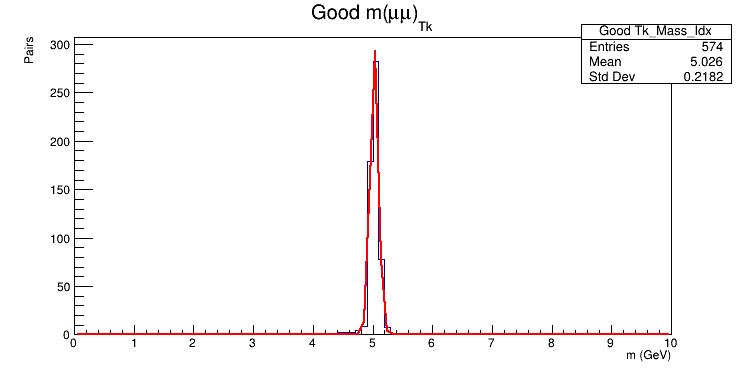

In [14]:
mass_data = hIdxTkPairMass.GetValue()
print(f"{mass_data}")
#ROOT.gROOT.SetStyle("ATLAS")

c = ROOT.TCanvas("c","c",750,400)

fit = ROOT.TF1("fit", "[0]*exp(-0.5*((x-[1])/[2])^2)", 0, 10)
fit.SetParameter(1, 5)
fit.SetParameter(2, 0.33)
# for i in range(3):
#     fit.SetParameter(i, fit.GetParameter(i))

fit.SetLineColor(2)
fit.SetLineStyle(1)
fit.SetLineWidth(2)
mass_data.Draw()
mass_data.Fit("fit", "0", "", 0, 10)
fit.Draw("SAME")
c.Draw()

In [15]:
ROOT.TObject(hIdxTkPairMass)

TypeError: none of the 2 overloaded methods succeeded. Full details:
  TObject::TObject() =>
    TypeError: takes at most 0 arguments (1 given)
  TObject::TObject(const TObject& object) =>
    TypeError: could not convert argument 1